In [1]:
from tensorflow.keras.models import load_model
import nibabel as nib
from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2


C:\ProgramData\Miniconda3\envs\TFM\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# Define constants
HOUNSFIELD_MIN = 0
HOUNSFIELD_MAX = 1
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = False
SLICE_Y = False
SLICE_Z = True

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [3]:
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [4]:
targetName = 'Paciente82'
targetImagePath = f'data/volumes/predict/img/{targetName}.nii'
targetMaskPath  = f'data/volumes/predict/mask/{targetName}.nii'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
imgMask = imgMaskNii.get_fdata()

In [5]:
model = load_model('UNET-ProstataSegmentation_224_224_2006x877.h5')

In [6]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [7]:
sliceIndex = 80

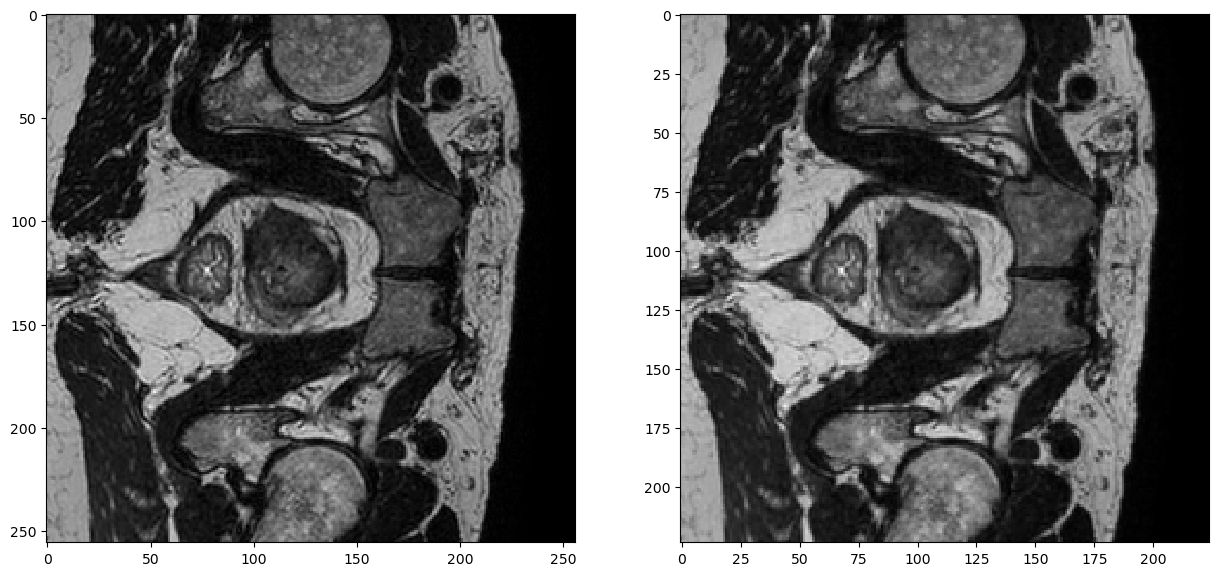

((256, 256), (224, 224))

In [8]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[:,:,sliceIndex]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

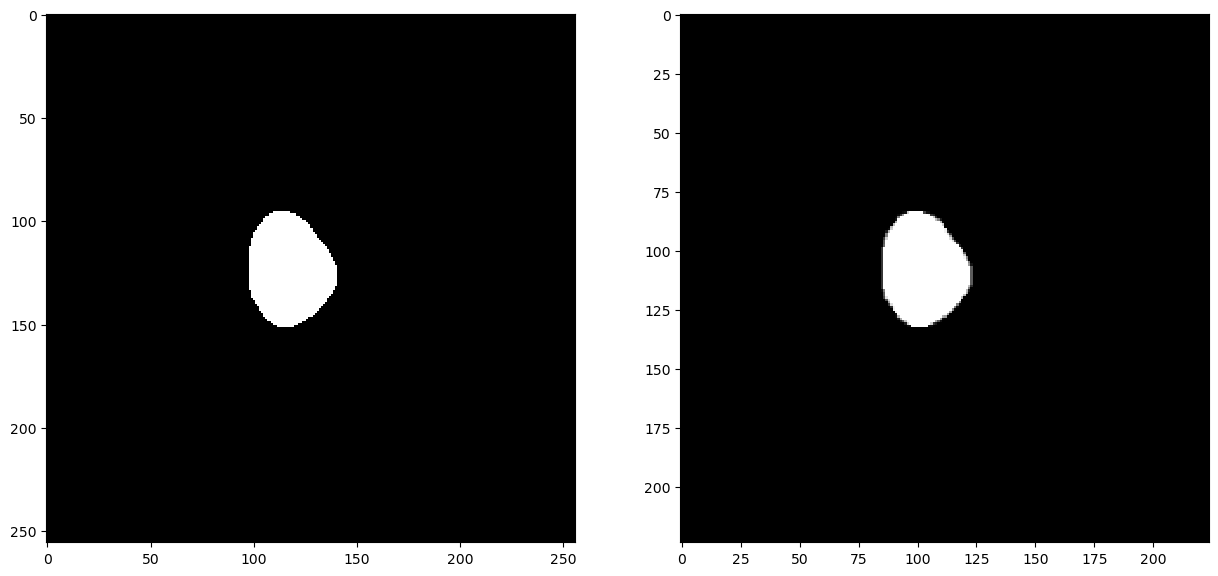

((256, 256), (224, 224))

In [9]:
# show input mask slice
plt.figure(figsize=(15,15))

maskSlice = imgMask[:,:,sliceIndex]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

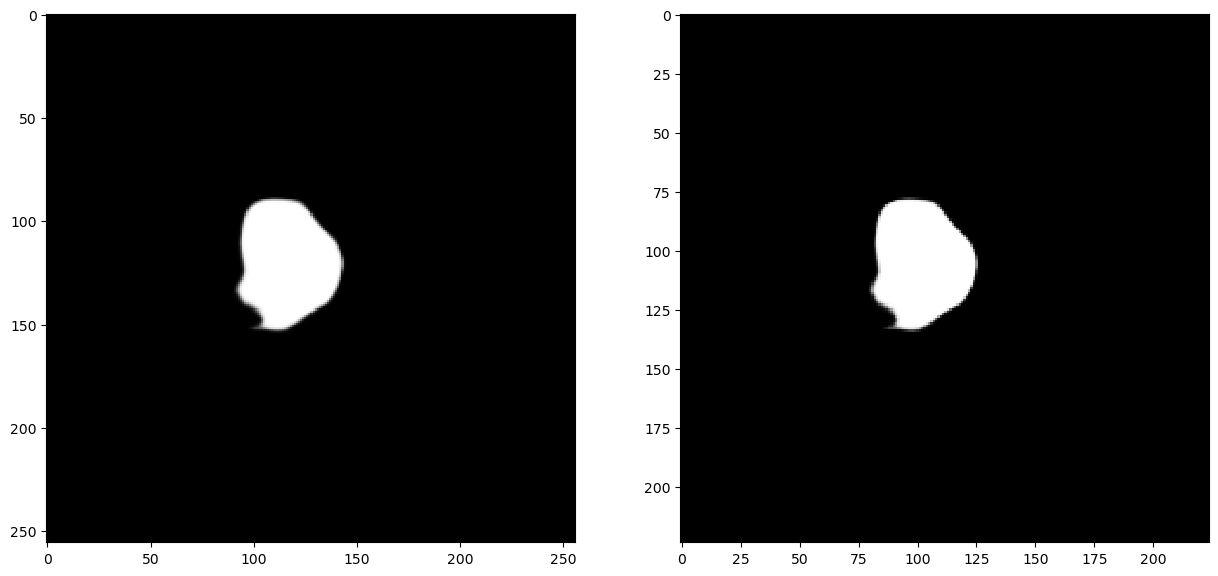

((256, 256), (224, 224))

In [10]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

In [11]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [12]:
predImg = predictVolume(imgTarget)

In [13]:
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

In [14]:
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(predImg))
my_widget.nifti_plotter(colormap='gray')

<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

In [15]:
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

In [16]:
from skimage.measure import marching_cubes_lewiner

In [17]:
vertices,faces,_,_ = marching_cubes_lewiner(predImg)

In [18]:
import meshplot as mp

In [19]:
mp.plot(vertices, faces, return_plot=False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(131.5, 10…

In [20]:
from stl import mesh

In [21]:
def dataToMesh(vert, faces):
    mm = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            mm.vectors[i][j] = vert[f[j],:]
    return mm

In [22]:
mm = dataToMesh(vertices, faces)
mm.save('Paciente82.stl')

In [25]:
# import the necessary packages
from collections import namedtuple
import numpy as np
import cv2
# define the `Detection` object
Detection = namedtuple("Detection", ["targetImagePath", "imgMaskNii", "predImg"])

In [27]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
# define the list of example detections
examples = [
	Detection("image_0002.jpg", [39, 63, 203, 112], [54, 66, 198, 114]),
	Detection("image_0016.jpg", [49, 75, 203, 125], [42, 78, 186, 126]),
	Detection("image_0075.jpg", [31, 69, 201, 125], [18, 63, 235, 135]),
	Detection("image_0090.jpg", [50, 72, 197, 121], [54, 72, 198, 120]),
	Detection("image_0120.jpg", [35, 51, 196, 110], [36, 60, 180, 108])]

In [28]:
# loop over the example detections
for detection in examples:
	# load the image
	image = cv2.imread(detection.image_path)
	# draw the ground-truth bounding box along with the predicted
	# bounding box
	cv2.rectangle(image, tuple(detection.gt[:2]), 
		tuple(detection.gt[2:]), (0, 255, 0), 2)
	cv2.rectangle(image, tuple(detection.pred[:2]), 
		tuple(detection.pred[2:]), (0, 0, 255), 2)
	# compute the intersection over union and display it
	iou = bb_intersection_over_union(detection.gt, detection.pred)
	cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
	print("{}: {:.4f}".format(detection.image_path, iou))
	# show the output image
	cv2.imshow("Image", image)
	cv2.waitKey(0)

NameError: name 'examples' is not defined